In [1]:
import torch
import torchvision 
from torchvision import datasets, transforms
from torch import nn
from torch.utils.data import DataLoader, random_split, TensorDataset

from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.model_selection import train_test_split

In [2]:
def contar_parametros(model):
    total_parametros = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_parametros

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
import torchvision.datasets as datasets


mnist_dataset=datasets.MNIST(root='./data',train=True,download=False,transform=transforms.ToTensor())
mnist_testset=datasets.MNIST(root='./data',train=False,download=False,transform=transforms.ToTensor())

In [5]:
print(len(mnist_dataset))
print(len(mnist_testset))
print(len(mnist_dataset[0]))


60000
10000
2


In [6]:
def show_loaded_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))  # Ajustar el tamaño de la figura según el número de imágenes
    
    for i in range(num_images):
        # Convertir la imagen de BGR a RGB
        image_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        
        # Mostrar la imagen en la subtrama correspondiente
        axes[i].imshow(image_rgb)
        axes[i].axis('off')  # Desactivar los ejes
        axes[i].set_title(titles[i])  # Establecer el título de la subtrama
    
    plt.show()

In [7]:
#Mezclando datos
Dataset=mnist_dataset+mnist_testset
print(len(Dataset))

70000


In [8]:
train_size = int(0.8 * len(Dataset))  # 80% para entrenamiento
test_size = len(Dataset) - train_size  # 20% para prueba
train_dataset, test_dataset = random_split(Dataset, [train_size, test_size])

# Dividir el conjunto de entrenamiento en entrenamiento (90% de 80%) y validación (10% de 80%)
train_size = int(0.9 * len(train_dataset))  # 90% del conjunto de entrenamiento
val_size = len(train_dataset) - train_size  # 10% para validación
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [9]:
print(len(train_dataset))
print(len(test_dataset))
print(len(val_dataset))

50400
14000
5600


In [47]:
class Neural_network(nn.Module):
    def __init__(self, layers, neurons):
        super(Neural_network, self).__init__()
        
        self.flatten = nn.Flatten()  # Para aplanar las imágenes de 28x28
        
        # Definir las capas básicas
        basic_layers = []
        
        # Primera capa lineal
        
        if neurons<=1:
            neurons=1
        
        basic_layers.append(('fc1', nn.Linear(28*28, neurons)))
        #basic_layers.append(('relu1', nn.ReLU()))  # Aplicar ReLU después de la primera capa
        
        # Añadir capas ocultas adicionales si layers > 1
        for i in range(2, layers+2):
            basic_layers.append((f'fc{i+1}', nn.Linear(neurons, 10)))  # Capas adicionales
            #basic_layers.append((f'relu{i+1}', nn.ReLU()))  # ReLU para cada capa oculta
        
        # Capa de salida con Softmax (normaliza las salidas)
        basic_layers.append(('output', nn.Linear(neurons, 10)))  # Asumiendo una clasificación de 10 clases
        basic_layers.append(('softmax', nn.Softmax(dim=1)))  # Softmax en la última capa para clasificación

        # Crear la secuencia de capas con OrderedDict
        self.linear_stack = nn.Sequential(OrderedDict(basic_layers))
    
    def forward(self,x):
        x=self.flatten(x)
        logits=self.linear_stack(x)
        return logits

In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer,epochs):
    val_loss = 0.0
    accuracy=0.0
    accuracy_t=[]
    val_loss_t=[]
    
    for epoch in range(epochs):
        model.train()  # Modo de entrenamiento
        running_loss = 0.0
        
        # Entrenamiento en conjunto de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Limpiar los gradientes acumulados
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass y optimización
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()

        # Evaluar el modelo en el conjunto de validación
        model.eval()  # Modo de evaluación
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # No calcular gradientes durante validación
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calcular las predicciones correctas
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calcular las pérdidas promedio y precisión
        running_loss /= len(train_loader)
        val_loss /= len(val_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
        accuracy_t.append(accuracy)
        val_loss_t.append(val_loss)
    return [running_loss,val_loss,accuracy],accuracy_t,val_loss_t

In [12]:
models=[Neural_network(1,i*2) for i in range(0,16,4)]

In [13]:
params=[]
for model in models:
    print(contar_parametros(model))
    params.append(contar_parametros(model))

805
6370
12730
19090


In [14]:
from torchinfo import summary

summary(models[1], input_size=(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
Neural_network                           [1, 10]                   --
├─Flatten: 1-1                           [1, 784]                  --
├─Sequential: 1-2                        [1, 10]                   --
│    └─Linear: 2-1                       [1, 8]                    6,280
│    └─Linear: 2-2                       [1, 10]                   90
│    └─Softmax: 2-3                      [1, 10]                   --
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
Total mult-adds (M): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1000)
test_loader = DataLoader(test_dataset, batch_size=1000)


In [16]:
from copy import deepcopy
model_stats=[]
acc_models=[]
loss_models=[]
for model in models: 
    model=model.to(device)
    criterion = nn.CrossEntropyLoss() 
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    aux_stats,acc_hist,loss_hist=train_model(model,train_loader,val_loader,criterion,optimizer,epochs=50)
    acc_models.append(deepcopy(acc_hist))
    loss_models.append(deepcopy(loss_hist))
    model_stats.append(deepcopy(aux_stats))
    print(aux_stats)

Epoch 1/50, Loss: 2.2841, Val Loss: 2.2526, Accuracy: 0.2580
Epoch 2/50, Loss: 2.2320, Val Loss: 2.2174, Accuracy: 0.2629
Epoch 3/50, Loss: 2.2092, Val Loss: 2.2009, Accuracy: 0.2627
Epoch 4/50, Loss: 2.1964, Val Loss: 2.1911, Accuracy: 0.2652
Epoch 5/50, Loss: 2.1889, Val Loss: 2.1851, Accuracy: 0.2712
Epoch 6/50, Loss: 2.1837, Val Loss: 2.1809, Accuracy: 0.2759
Epoch 7/50, Loss: 2.1801, Val Loss: 2.1775, Accuracy: 0.2789
Epoch 8/50, Loss: 2.1767, Val Loss: 2.1746, Accuracy: 0.2818
Epoch 9/50, Loss: 2.1742, Val Loss: 2.1718, Accuracy: 0.2843
Epoch 10/50, Loss: 2.1713, Val Loss: 2.1692, Accuracy: 0.2854
Epoch 11/50, Loss: 2.1683, Val Loss: 2.1666, Accuracy: 0.2855
Epoch 12/50, Loss: 2.1651, Val Loss: 2.1640, Accuracy: 0.2855
Epoch 13/50, Loss: 2.1621, Val Loss: 2.1612, Accuracy: 0.2846
Epoch 14/50, Loss: 2.1589, Val Loss: 2.1584, Accuracy: 0.2895
Epoch 15/50, Loss: 2.1556, Val Loss: 2.1557, Accuracy: 0.2938
Epoch 16/50, Loss: 2.1526, Val Loss: 2.1530, Accuracy: 0.2977
Epoch 17/50, Loss

In [17]:
for stat in model_stats:
    print(stat)

[2.1058364101484712, 2.1117172241210938, 0.3507142857142857]
[1.532984679820491, 1.5409655570983887, 0.9230357142857143]
[1.5252230214137656, 1.5355114142100017, 0.9276785714285715]
[1.522617349437639, 1.5353114008903503, 0.9271428571428572]


In [26]:
acc=[i[2] for i in model_stats]
err=[i[-1] for i in loss_models]

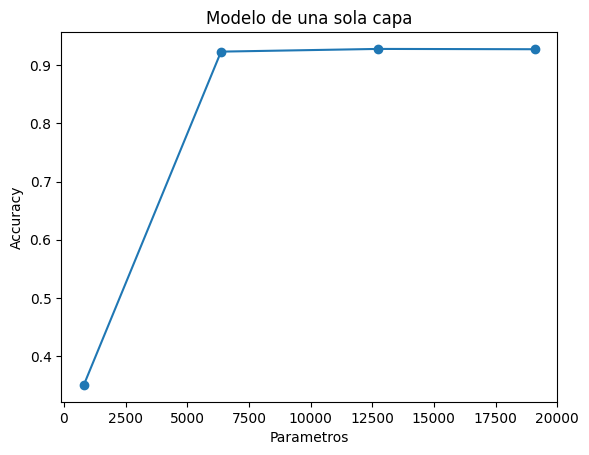

In [22]:
plt.plot(params,acc,marker='o')
plt.xlabel('Parametros')
plt.ylabel('Accuracy')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

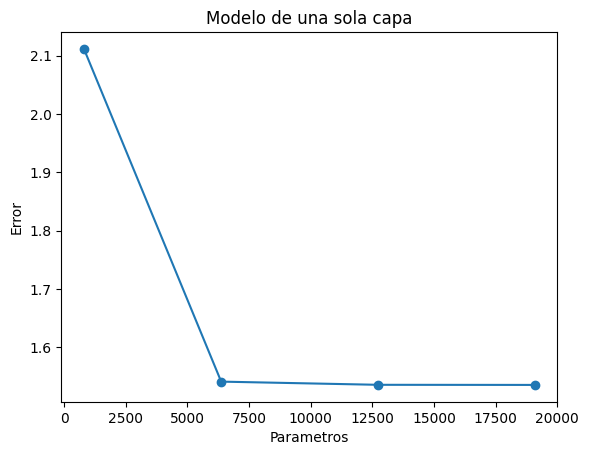

In [27]:
plt.plot(params,err,marker='o')
plt.xlabel('Parametros')
plt.ylabel('Error')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

In [24]:
neuronas=[i*2 for i in range(0,16, 4)]

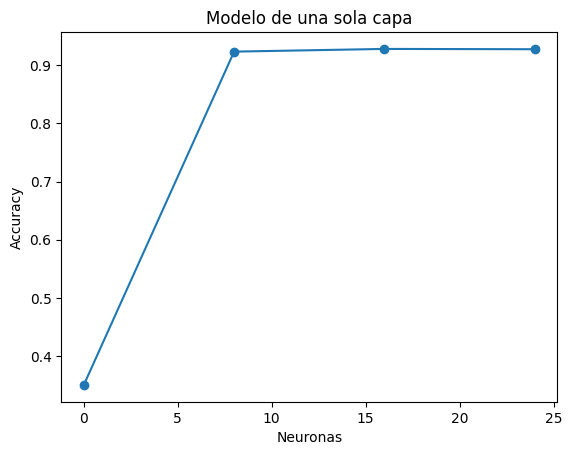

In [25]:
plt.plot(neuronas,acc,marker='o')
plt.xlabel('Neuronas')
plt.ylabel('Accuracy')

# Añadir un título
plt.title('Modelo de una sola capa')

# Mostrar la gráfica
plt.show()

## Redes de varias capas

In [48]:
models=[Neural_network(i,i*2) for i in range(0,16,4)]

In [49]:
params=[]
for model in models:
    print(contar_parametros(model))
    params.append(contar_parametros(model))

805
6730
14090
22090


In [51]:

summary(models[1], input_size=(1,28,28))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Flatten: 1, Linear: 2, Linear: 2]